Connect to database.

In [1]:
from sqlalchemy.engine.url import URL

DB_USERNAME = "bgd22_2804700" # YOUR USER NAME
DB_PASSWORD = "narCO42z" # YOUR PASSWORD
DB_SCHEMA = "public"
DB_HOSTNAME="gip.itc.utwente.nl"
DB_PORT=5434
DB_DATABASE="c211"



postgres_db = {'drivername': 'postgresql',
               'username': DB_USERNAME,
               'password': DB_PASSWORD,
               'host': DB_HOSTNAME,
               'port': DB_PORT,
               'database': DB_DATABASE}

db_url = URL.create(**postgres_db)


In [2]:
from sqlalchemy import create_engine, Column, Integer, String

engine = create_engine(
    db_url, isolation_level="AUTOCOMMIT", pool_size=10, max_overflow=20)

Prepare dataset.

In [3]:
import pandas as pd
dataout_path = '0_data/' # Should create this folder to store data.

1. Target variable(s) data.

This is a spatio-temporal dataset, resolution is block-daily. Time range is half 2017 (because days database is end at 2017-06-30).
Target variable is number of observations in spatio-temporal resolution. (And also acquire number of observers, number of species.)

In [4]:
df2017st_observations_query = "SELECT block, obsdate, COUNT(DISTINCT observer) as nb_observers, COUNT(*) as nb_observations, COUNT(DISTINCT species) as nb_species "\
    "FROM public.observation "\
    "WHERE latit != '0' "\
    "AND obsdate >= '2017-01-01' AND obsdate <= '2017-06-30' "\
    "GROUP BY block, obsdate;"
    

df2017st_observations = pd.read_sql(df2017st_observations_query, engine)  
df2017st_observations.head()

,block,obsdate,nb_observers,nb_observations,nb_species
0,60,2017-02-05,1,1,1
1,61,2017-03-13,1,1,1
2,61,2017-06-08,1,7,7
3,62,2017-02-05,1,1,1
4,62,2017-02-25,2,2,1


In [5]:
df2017st_observations.shape

(538524, 5)

2. Spatio-temporal features data.

This is spatio-temporal input features data, including precipitation, temperature, and days (this is only temporal, but need to join it with precipitation and temperature.)

In [6]:
df2017stfeatures_query = "SELECT dy.odate AS obsdate, doy, dow, natholiday AS holiday, prec.block, prec.precip, temp.temper "\
    "FROM public.days AS dy, public.precipitation AS prec, public.temperature as temp "\
    "WHERE dy.mdate = prec.dtime AND dy.mdate = temp.dtime AND prec.dtime = temp.dtime AND prec.block = temp.block "\
    "AND dy.odate >= '2017-01-01' AND dy.odate <= '2017-06-30';"

df2017stfeatures = pd.read_sql(df2017stfeatures_query, engine)  
df2017stfeatures.head()

,obsdate,doy,dow,holiday,block,precip,temper
0,2017-01-01,1,0,True,27,6.048740,1.50182
1,2017-01-02,2,1,False,27,0.460640,7.25872
2,2017-01-03,3,2,False,27,0.558334,6.31733
3,2017-01-04,4,3,False,27,1.106020,7.74568
4,2017-01-05,5,4,False,27,0.000000,5.50785


In [7]:
df2017stfeatures.shape

(7280892, 7)

3. Spatial features data.

This is spatial input features data, including block_biodiversity, block_demography, block_road_access, and NDVI

In [8]:
# Before acquire spatial features, first process block_road_access to combine all access road length.
dfroadnowater_query = "SELECT * "\
    "FROM public.block_road_access "\
    "WHERE maintainer != 'W';"

dfroadnowater = pd.read_sql(dfroadnowater_query, engine)  
dfroadnowater.head()

,block,maintainer,scale,roadlength
0,62,G,1,656.363163
1,62,P,1,1187.960076
2,63,G,1,12193.064129
3,64,G,1,1526.461025
4,66,G,1,1257.901412


In [9]:
dfroadnowater.shape

(44952, 4)

In [10]:
block_max_id = dfroadnowater['block'].max()
import numpy as np
# Initial array to calculate no water road length sum.
arrayroadnowater = np.zeros(block_max_id + 1)
# Do length sum.
for i in range(len(dfroadnowater)):
    block_id = dfroadnowater.iat[i, 0]
    curret_length = dfroadnowater.iat[i, 3]
    arrayroadnowater[block_id] = arrayroadnowater[block_id] + curret_length

# save result.
import csv
roadnowater_file = dataout_path + 'roadnowater.csv' 
csv_header = ["block", "roads_nowater_length"]
with open (roadnowater_file, "w", newline = '') as roadnowater_data:
    roadnowater_csv = csv.writer(roadnowater_data)
    roadnowater_csv.writerow(csv_header)
    for j in range(len(arrayroadnowater)):
        block_id = j
        roadnowater_length = arrayroadnowater[j]
        if roadnowater_length > 0:
            roadnowater_writerow = [j, roadnowater_length]
            roadnowater_csv.writerow(roadnowater_writerow)

In [11]:
dfspatial_query = "SELECT b.*,  bio.aves2012_2016, pop.pop001 "\
    "FROM public.block AS b, public.biodiversity AS bio, public.block_demography AS pop "\
    "WHERE b.latit != '0' "\
    "AND b.block = bio.block AND b.block = pop.block;"
# Don't use landuse here, because block is not unique in block_landuse.
dfspatial = pd.read_sql(dfspatial_query, engine)  
dfspatial.head()

,block,longit,latit,geom,urlnr,aves2012_2016,pop001
0,60,15,367,010300002040710000010000000500000000000000004C...,630182,16,10
1,61,15,368,010300002040710000010000000500000000000000004C...,630183,25,0
2,62,15,369,010300002040710000010000000500000000000000004C...,630184,13,30
3,63,15,370,010300002040710000010000000500000000000000004C...,630185,66,1700
4,64,15,371,010300002040710000010000000500000000000000004C...,630186,40,235


In [12]:
dfspatial.shape

(37544, 7)

In [13]:
# Connect dfspatial and road data.
dfroad_length = pd.read_csv(dataout_path + 'roadnowater.csv')
dfroad_length.head()

,block,roads_nowater_length
0,62,1844.323239
1,63,12193.064129
2,64,1526.461025
3,66,1257.901412
4,68,6936.806033


In [14]:
# Execute ndvi value fro blocks from database
df_ndvi_query = "SELECT block, ndvi "\
    "FROM bgd22_2804700.block_ndvi;"
   

df_ndvi = pd.read_sql(df_ndvi_query, engine)  
df_ndvi.head()

,block,ndvi
0,23984,-0.324561
1,24238,-0.346197
2,24492,-0.349943
3,24746,-0.351852
4,25000,-0.329298


In [18]:
df_ndvi.shape

(44269, 2)

In [19]:
dfspatial_road_demography = pd.merge(dfspatial, dfroad_length, on = 'block')
dfspatialall = pd.merge(dfspatial_road_demography, df_ndvi, on = 'block')
dfspatialall.head()

,block,longit,latit,geom,urlnr,aves2012_2016,pop001,roads_nowater_length,ndvi
0,62,15,369,010300002040710000010000000500000000000000004C...,630184,13,30,1844.323239,0.417693
1,63,15,370,010300002040710000010000000500000000000000004C...,630185,66,1700,12193.064129,0.482932
2,64,15,371,010300002040710000010000000500000000000000004C...,630186,40,235,1526.461025,0.581983
3,66,15,375,010300002040710000010000000500000000000000004C...,630188,120,140,1257.901412,0.552115
4,68,15,377,010300002040710000010000000500000000000000004C...,630190,87,10,6936.806033,0.430350


In [20]:
dfspatialall.shape

(32658, 9)

Now connect all data to acquire the final dataset for implementation.

In [21]:
df2017standst = pd.merge(df2017st_observations, df2017stfeatures, left_on = ['block', 'obsdate'], right_on = ['block','obsdate'])
df2017standst.head()

,block,obsdate,nb_observers,nb_observations,nb_species,doy,dow,holiday,precip,temper
0,60,2017-02-05,1,1,1,36,0,False,0.235353,7.46328
1,61,2017-03-13,1,1,1,72,1,False,0.000000,11.59240
2,61,2017-06-08,1,7,7,159,4,False,4.093030,23.41180
3,62,2017-02-05,1,1,1,36,0,False,0.235353,7.42724
4,62,2017-02-25,2,2,1,56,6,False,0.585078,9.28602


In [22]:
df2017standst.shape

(536163, 10)

In [23]:
df2017stall = pd.merge(df2017standst, dfspatialall, on = 'block')
df2017stall.head()

,block,obsdate,nb_observers,nb_observations,nb_species,doy,dow,holiday,precip,temper,longit,latit,geom,urlnr,aves2012_2016,pop001,roads_nowater_length,ndvi
0,62,2017-02-05,1,1,1,36,0,False,0.235353,7.42724,15,369,010300002040710000010000000500000000000000004C...,630184,13,30,1844.323239,0.417693
1,62,2017-02-25,2,2,1,56,6,False,0.585078,9.28602,15,369,010300002040710000010000000500000000000000004C...,630184,13,30,1844.323239,0.417693
2,62,2017-04-18,1,1,1,108,2,False,0.474744,10.80520,15,369,010300002040710000010000000500000000000000004C...,630184,13,30,1844.323239,0.417693
3,63,2017-01-21,1,5,4,21,6,False,0.000000,3.64525,15,370,010300002040710000010000000500000000000000004C...,630185,66,1700,12193.064129,0.482932
4,63,2017-02-05,1,8,8,36,0,False,0.235353,7.41745,15,370,010300002040710000010000000500000000000000004C...,630185,66,1700,12193.064129,0.482932


In [24]:
df2017stall.shape

(492282, 18)

In [59]:
# Save the prepared dataset to csv in crib
df2017stall.to_csv(dataout_path + '2017stall.csv')

In [33]:
# Save the prepared dataset to database
df2017stall.to_sql('2017stall', engine)

282

array([[<AxesSubplot: title={'center': 'nb_observers'}>,
        <AxesSubplot: title={'center': 'precip'}>],
       [<AxesSubplot: title={'center': 'temper'}>,
        <AxesSubplot: title={'center': 'pop001'}>],
       [<AxesSubplot: title={'center': 'roads_nowater_length'}>,
        <AxesSubplot: title={'center': 'ndvi'}>]], dtype=object)

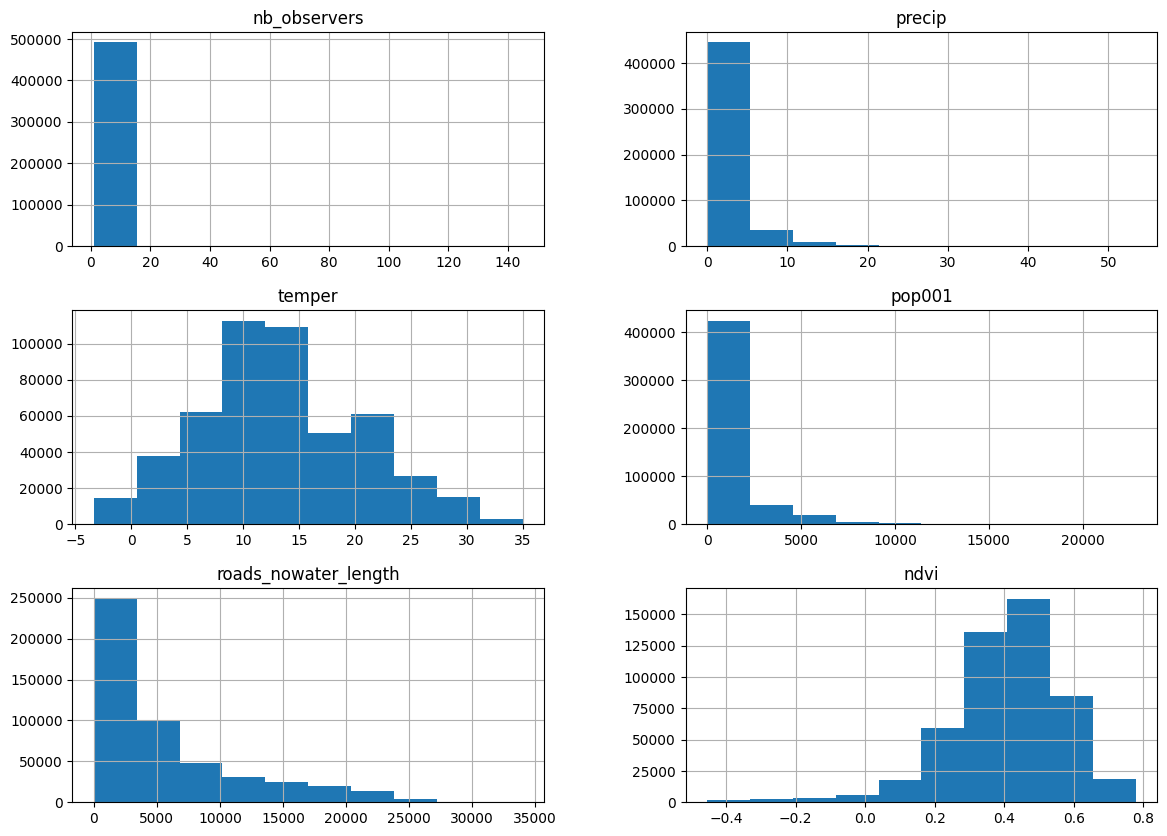

In [31]:
# 
df2017stall.hist(column=['nb_observers', 'precip', 'temper', 'pop001', 'roads_nowater_length', 'ndvi'],bins=10, figsize=(14, 10))